In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from glob import glob
from uuid import uuid4
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
startech_df = pd.concat(
    [pd.read_excel(path) for path in glob("./datasets/scrapped_data/*")]
)
print(startech_df.shape)
startech_df = startech_df.dropna().reset_index(drop=True).copy()
startech_df["id"] = [str(uuid4()) for _ in range(startech_df.shape[0])]
startech_df = startech_df[["id", "name", "price", "category", "specification"]]
print(startech_df.shape)
startech_df.head(5)

In [ ]:
startech_df_first_half = (
    startech_df.iloc[0 : startech_df.shape[0] // 2].reset_index(drop=True).copy()
)
startech_df_last_half = (
    startech_df.iloc[startech_df.shape[0] // 2 :].reset_index(drop=True).copy()
)

startech_df.to_excel("./datasets/startech.xlsx", index=False, engine="xlsxwriter")
startech_df_first_half.to_excel(
    "./startech_first_half.xlsx", index=False, engine="xlsxwriter"
)
startech_df_last_half.to_excel(
    "./startech_last_half.xlsx", index=False, engine="xlsxwriter"
)

## Join generated queries dataframe with main dataset


In [2]:
def format_product_details(name, price, specification):
    product_details = ""
    if specification is not None:
        product_details = f"Name: {name}\nPrice: {price} taka\n{specification.strip()}"
    else:
        product_details = f"Name: {name}\nPrice: {price} taka"

    return product_details

In [3]:
query_df = [pd.read_excel(path) for path in glob("./datasets/generated_data/*.xlsx")]
query_df = pd.concat(query_df)
print(query_df.shape)
query_df.head(5)

(44417, 2)


,id,relevant_query
0,ff9f4b9c-64f8-4b20-8cbb-698db1302f05,budget gaming desktop pc
1,ff9f4b9c-64f8-4b20-8cbb-698db1302f05,entry level desktop computer
2,ff9f4b9c-64f8-4b20-8cbb-698db1302f05,small form factor pc build
3,ff9f4b9c-64f8-4b20-8cbb-698db1302f05,gaming pc with integrated graphics
4,ff9f4b9c-64f8-4b20-8cbb-698db1302f05,AMD Ryzen 5 desktop processor


In [4]:
product_df = pd.read_excel("./datasets/startech.xlsx")
print(product_df.shape)
product_df.head(5)

(6334, 5)


,id,name,price,category,specification
0,ff9f4b9c-64f8-4b20-8cbb-698db1302f05,AMD Ryzen 5 5600G Budget Desktop PC,26699,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
1,34c772a6-ef7d-4f3c-ae95-3c8acff1a1b4,AMD Ryzen 5 5600G Desktop PC,29500,Star PC,Processor: AMD Ryzen 5 5600G Processor with Ra...
2,e3c3d67a-5138-481b-930c-dcb64ea67b93,Intel 12th Gen Core i5-12400 Desktop PC,31200,Star PC,Processor: Intel 12th Gen Core i5-12400 Alder ...
3,797a3b0a-8c2b-4cf6-8a90-2f36a82bd722,AMD Ryzen 7 5700G Custom Desktop PC,32400,Star PC,Processor: AMD Ryzen 7 5700G Processor with Ra...
4,71be6c35-b744-4b69-8f1b-ee665c29a76a,AMD Ryzen 5 8500G Desktop PC,37499,Star PC,Processor: AMD Ryzen 5 8500G Processor with Ra...


## Adding category to query dataframe


In [5]:
query_df = query_df.merge(product_df[["id", "category"]], on="id", how="left").copy()
print(query_df.shape)
query_df.tail(10)

(44417, 3)


,id,relevant_query,category
44407,56c303df-c2f8-4121-a7be-c4eacff2069e,compact garment steamer for travel,Iron
44408,56c303df-c2f8-4121-a7be-c4eacff2069e,Panasonic NI-GSE040PTH Garment Steamer,Iron
44409,56c303df-c2f8-4121-a7be-c4eacff2069e,Panasonic NI-GSE040PTH Pink Garment Steamer,Iron
44410,a00a4134-03d9-462c-bd4e-c947f61cf40b,powerful garment steamer for wrinkles,Iron
44411,a00a4134-03d9-462c-bd4e-c947f61cf40b,portable steam spray cleaner for clothes,Iron
44412,a00a4134-03d9-462c-bd4e-c947f61cf40b,best way to remove wrinkles from fabrics,Iron
44413,a00a4134-03d9-462c-bd4e-c947f61cf40b,compact steam iron for delicate items,Iron
44414,a00a4134-03d9-462c-bd4e-c947f61cf40b,effective fabric steamer with spray function,Iron
44415,a00a4134-03d9-462c-bd4e-c947f61cf40b,Panasonic NI-GSE050ATH Garment Steamer,Iron
44416,a00a4134-03d9-462c-bd4e-c947f61cf40b,NI-GSE050ATH steam iron specifications,Iron


## For every product of a category, take positive query from other categories


In [6]:
category_list = list(product_df["category"].unique())
print(f"Num categories: {len(category_list)}")

train_dict = {"category": [], "anchor": [], "positive": [], "negative": []}

for idx, row in tqdm(product_df.iterrows(), total=product_df.shape[0]):
    id = row["id"]
    name = row["name"]
    price = row["price"]
    specification = row["specification"]
    category = row["category"]

    anchor = format_product_details(name, price, specification)

    positive_queries = query_df[query_df["id"] == id]["relevant_query"].tolist()
    num_positive_queries = len(positive_queries)

    # take num_positive_queries random categories except current category
    random_categories = np.random.choice(
        product_df[product_df["category"] != category]["category"].unique().tolist(),
        num_positive_queries,
        replace=False,
    )

    for random_category in random_categories:
        random_query = np.random.choice(
            list(query_df[query_df["category"] == random_category]["relevant_query"]),
            1,
            replace=False,
        )[0]
        train_dict["negative"].append(str(random_query))

    train_dict["category"].extend([category] * num_positive_queries)
    train_dict["anchor"].extend([anchor] * num_positive_queries)
    train_dict["positive"].extend(positive_queries)

Num categories: 166


  0%|          | 0/6334 [00:00<?, ?it/s]

In [7]:
all_data = pd.DataFrame.from_dict(train_dict)
all_data.sample(10).head(10)

,category,anchor,positive,negative
9552,Monitor,"Name: Viewsonic VX3211-4K-mhd 32"" 4K Entertain...",4k monitor for immersive gaming,Asustor DRIVESTOR 4 Pro AS3304T
10467,Online UPS,Name: Marsriva MR-US10KRT-H Energy Efficient 1...,silent backup power supply,A4TECH W70 Max RGB Gaming Mouse
43527,Geyser,Name: Shameem Tropica 15 Gallon Special Geyser...,personal hot water device,powerful iMac for creative work
22278,Router,Name: Cudy M1800 AX1800 Dual Band Mesh Router ...,reliable wifi for streaming and gaming,U/UTP cable for networking
24472,Patch Cord,Name: Safenet 34-3031OR 3 Meter Cat6 LSZH UTP ...,Orange network cable for data transmission,monitor with srgb color gamut 2k
15275,POS Printer,Name: Xprinter XP80T Thermal Receipt Printer\n...,industrial receipt printer,reliable wireless network coverage
22372,Router,Name: Tenda RX9 Pro AX3000 Dual Band Gigabit W...,fast home wifi router,Cooler Master G700 Gold 700W 80 Plus Gold
42792,Android TV,"Name: Sony Bravia XR-85X90K 85"" 4K Ultra HD LE...",high refresh rate tv for gaming,mini bluetooth audio transmitter
35799,Microphone,Name: SYNCO WMic-T1 Camera-Mount 16-Channel UH...,wireless microphone for interviews,Hikvision 4 channel DVR
40111,Neckband,Name: Riversong EA65 Stream N+ Bluetooth Neckb...,wireless neckband earphones,fast m2 nvme ssd for gaming


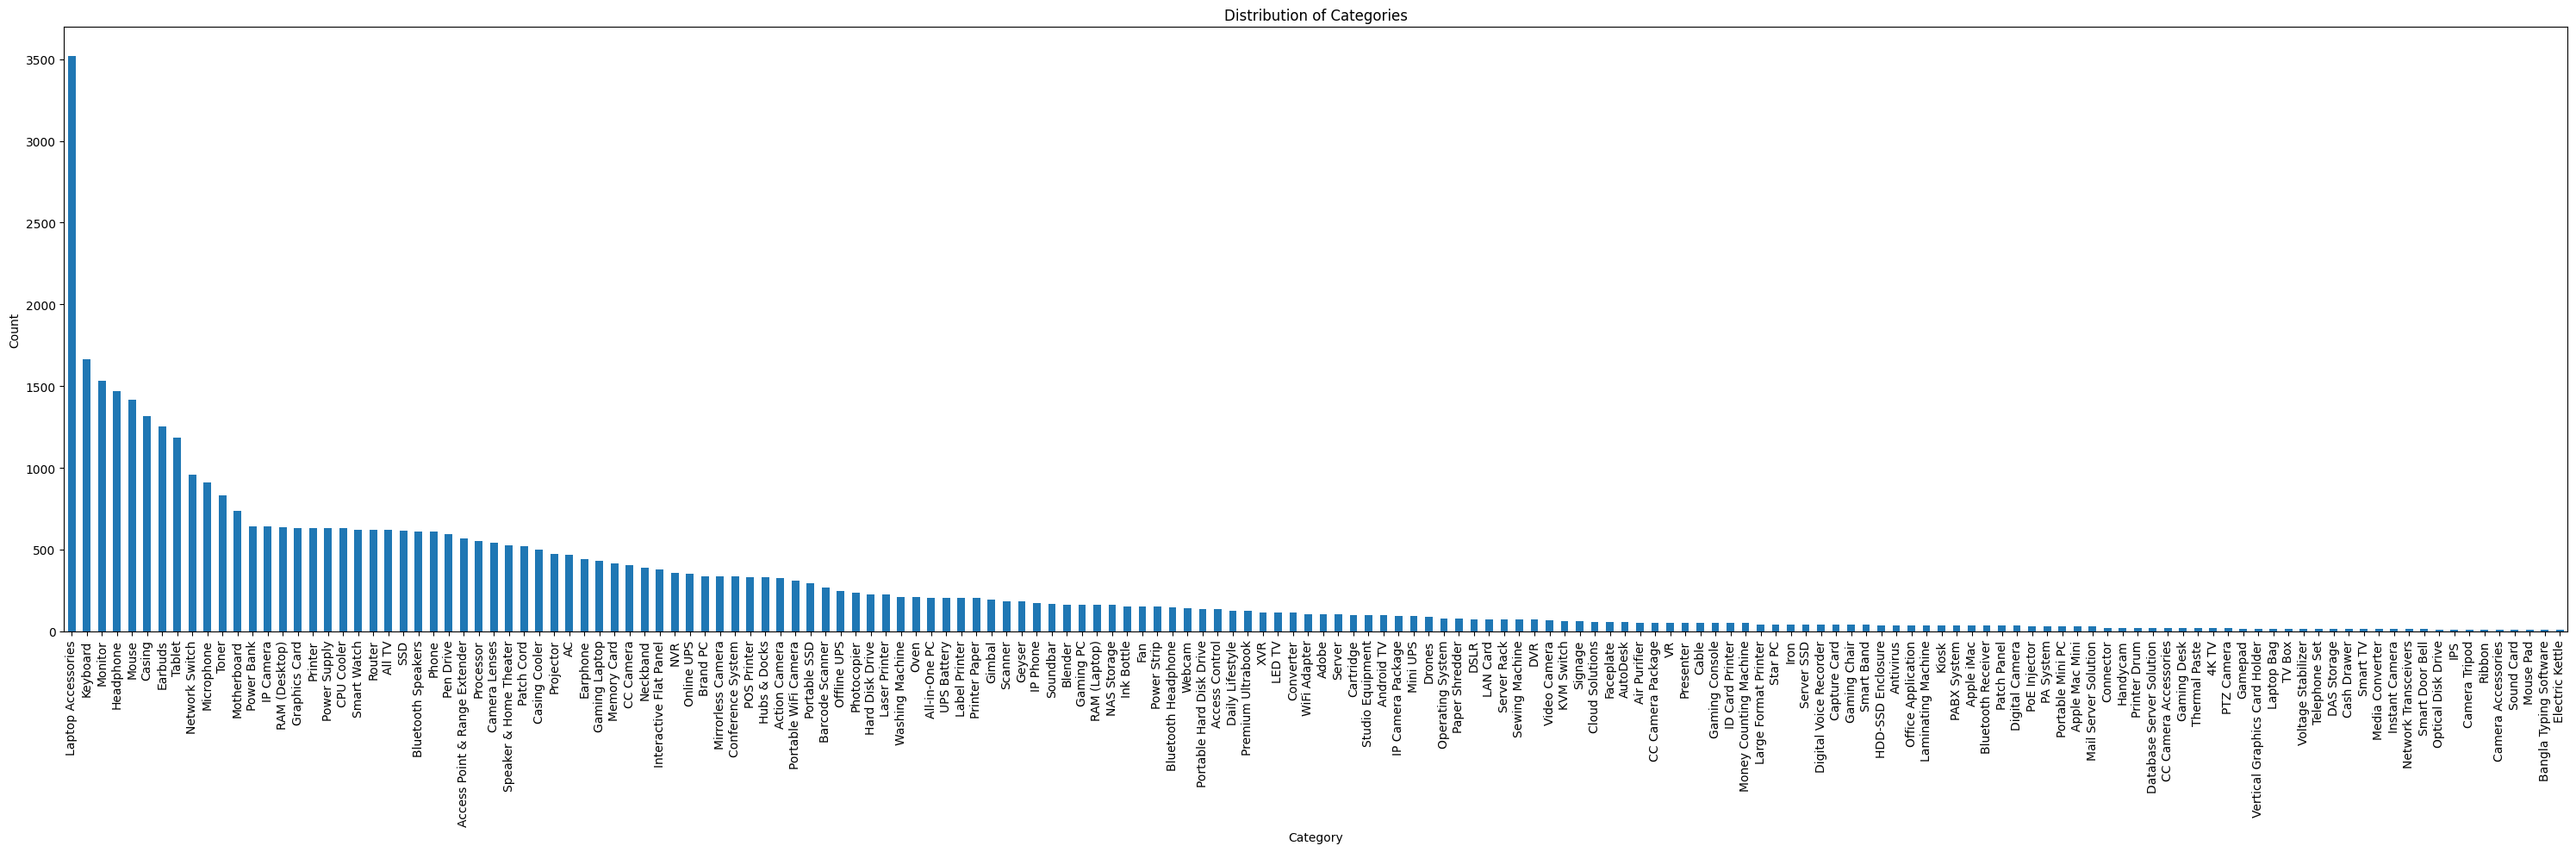

In [8]:
plt.figure(figsize=(30, 10))
all_data["category"].value_counts().plot(kind="bar")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Categories")
plt.tight_layout()
plt.show()

## Dataset split


In [14]:
train_df, val_df = train_test_split(
    all_data,
    test_size=0.10,
    random_state=42,
    stratify=all_data["category"],
    shuffle=True,
)
train_df, test_df = train_test_split(
    train_df,
    test_size=0.20,
    random_state=42,
    stratify=train_df["category"],
    shuffle=True,
)

train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

train_df.shape, val_df.shape, test_df.shape

((31980, 4), (4442, 4), (7995, 4))

In [15]:
train_df.to_csv("./datasets/train.csv", index=False)
test_df.to_csv("./datasets/test.csv", index=False)
val_df.to_csv("./datasets/val.csv", index=False)